In [1]:
################################################################################
###########################  Amazon Reviews  ###################################
###########################  Ranking System  ###################################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install and import packages
!pip install tensorflow-recommenders
!pip install --upgrade tensorflow-datasets
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from typing import Dict, Text
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import datetime
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('\n')

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Tue May 10 03:22:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [5]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [6]:
init_seeds(seed=42)

In [7]:
# Set seed 
seed_value = 42
os.environ['AmazonReviews_RecSysDL'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Examine and Process Data

In [ ]:
%cd /content/drive/MyDrive/AmazonReviews/Data/

/content/drive/MyDrive/AmazonReviews/Data


In [ ]:
# Read data
df = pd.read_csv('Clothing_Shoes_and_Jewelry.csv', header=None, skiprows=[0],
                 low_memory=False)
df = df.drop_duplicates()
df.columns = ['reviewerID','item','rating','timestamp']
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (31697963, 4)


,reviewerID,item,rating,timestamp
0,0871167042,A3OT9BYASFGU2X,4.0,1398470400
1,0871167042,A28GK1G2KDXHRP,5.0,1397692800
2,0871167042,A3NFXFEKW8OK0E,5.0,1397606400
3,0871167042,A3I6G5TKBVJEK9,5.0,1397520000
4,0871167042,A1A7Y1M8AJWNZ8,5.0,1396224000


In [ ]:
# Data summary
def data_summary(df):
    print('Number of Rows: {}, Columns: {}'.format(df.shape[0] ,df.shape[1]))
    a = pd.DataFrame()
    a['Number of Unique Values'] = df.nunique()
    a['Number of Missing Values'] = df.isnull().sum()
    a['Data type of variable'] = df.dtypes
    print(a)

print('\nInitial Data Summary')     
print(data_summary(df))

# Remove timestamp column
df = df.drop(['timestamp'], axis = 1) 


Initial Data Summary
Number of Rows: 31697963, Columns: 4
            Number of Unique Values  Number of Missing Values  \
reviewerID                  2681297                         0   
item                       12483678                         0   
rating                            5                         0   
timestamp                      5393                         0   

           Data type of variable  
reviewerID                object  
item                      object  
rating                   float64  
timestamp                  int64  
None


In [ ]:
# Create new integer id for item due to sparsity
value_counts = df['item'].value_counts(dropna=True, sort=True)
df1 = pd.DataFrame(value_counts)
df1 = df1.reset_index()
df1.columns = ['item_unique', 'counts'] # name columns 
df1 = df1.reset_index()
df1.rename(columns={'index': 'item_id'}, inplace=True)
df1 = df1.drop(['counts'], axis=1)

In [ ]:
# Join to add int item id
df = pd.merge(df, df1, how='left', left_on=['item'], 
               right_on=['item_unique'])
df = df.drop(['item_unique'], axis=1)
df = df.drop_duplicates()

del value_counts, df1

In [ ]:
# Create new integer id for reviewerID due to sparsity
value_counts = df['reviewerID'].value_counts(dropna=True, sort=True)
df1 = pd.DataFrame(value_counts)
df1 = df1.reset_index()
df1.columns = ['id_unique', 'counts'] 
df1 = df1.reset_index()
df1.rename(columns={'index': 'reviewer_id'}, inplace=True)

df1 = df1.drop(['counts'], axis=1)

In [ ]:
# Join to add int reviewer id
df = pd.merge(df, df1, how='left', left_on=['reviewerID'], 
               right_on=['id_unique'])
df = df.drop(['id_unique'], axis=1)
df = df.drop_duplicates()

del value_counts, df1

In [ ]:
print(data_summary(df))

Number of Rows: 31675801, Columns: 5
             Number of Unique Values  Number of Missing Values  \
reviewerID                   2681297                         0   
item                        12483678                         0   
rating                             5                         0   
item_id                     12483678                         0   
reviewer_id                  2681297                         0   

            Data type of variable  
reviewerID                 object  
item                       object  
rating                    float64  
item_id                     int64  
reviewer_id                 int64  
None


In [ ]:
# Create key for merging new integer id variables for later join
df1 = df[['item', 'item_id', 'reviewerID','reviewer_id', 'rating']]
df1.to_csv('Clothing_Shoes_and_Jewelry_idMatch.csv', index = False)

del df1

In [ ]:
# Drop unnecessary keys
df = df.drop(['item', 'reviewerID'], axis=1)
df.shape

(31675801, 3)

In [8]:
# Starting point to avoid preprocessing
%cd /content/drive/MyDrive/AmazonReviews/Data/

# Read data
df = pd.read_csv('Clothing_Shoes_and_Jewelry_idMatch.csv', low_memory=False)
df = df.drop_duplicates()
df = df.drop(['item', 'reviewerID'], axis=1)

print('Number of rows and columns:', df.shape)
df.head()

/content/drive/MyDrive/AmazonReviews/Data
Number of rows and columns: (31675801, 3)


,item_id,reviewer_id,rating
0,8604928,124382,4.0
1,12337771,124382,5.0
2,9897857,124382,5.0
3,9897856,124382,5.0
4,5356266,124382,5.0


In [9]:
# Filter to greater than or equal to 1500 due to sparsity
reviewer_count = df.reviewer_id.value_counts()
df = df[df.reviewer_id.isin(reviewer_count[reviewer_count >= 1500].index)]
df = df.drop_duplicates()

# Data summary
def data_summary(df):
    print('Number of Rows: {}, Columns: {}'.format(df.shape[0] ,df.shape[1]))
    a = pd.DataFrame()
    a['Number of Unique Values'] = df.nunique()
    a['Number of Missing Values'] = df.isnull().sum()
    a['Data type of variable'] = df.dtypes
    print(a)

print('\nFiltered Data Summary')     
print(data_summary(df))

del reviewer_count


Filtered Data Summary
Number of Rows: 3113643, Columns: 3
             Number of Unique Values  Number of Missing Values  \
item_id                      1757869                         0   
reviewer_id                     1138                         0   
rating                             5                         0   

            Data type of variable  
item_id                     int64  
reviewer_id                 int64  
rating                    float64  
None


In [10]:
# Convert data types
df = df.copy()
df[['reviewer_id','item_id']] = df[['reviewer_id','item_id']].astype('str')
df['rating'] = df['rating'].astype('float32')

## Load Data into a Tensorflow Dataset and Prepare for Modeling

In [11]:
# Load pandas df to tf
ratings = tf.data.Dataset.from_tensor_slices(dict(df))

In [12]:
# Map the vars in tf Dataseet
ratings = ratings.map(lambda x: {
    'item': x['item_id'],
    'reviewer_id': x['reviewer_id'],
    'rating': x['rating']
})

In [13]:
# Prepare train/test sets
shuffled = ratings.shuffle(1_000_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(800_000)
test = shuffled.skip(800_000).take(200_000)

In [15]:
# Generate vocab that maps feature to embedding vector in model
items = ratings.batch(3_000_000).map(lambda x: x['item'])
reviewer_ids = ratings.batch(3_000_000).map(lambda x: x['reviewer_id'])

# Find unique items and reviewer_ids for vocab
unique_items = np.unique(np.concatenate(list(items)))
unique_reviewer_ids = np.unique(np.concatenate(list(reviewer_ids)))

## Define Model Architecture and Metrics

In [16]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 64

    # Compute embeddings for reviewers
    self.reviewer_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_reviewer_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_reviewer_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for items
    self.item_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_items, mask_token=None),
      tf.keras.layers.Embedding(len(unique_items) + 1, embedding_dimension)
    ])

    # Compute predictions
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      # Make rating predictions in the final layer
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):

    reviewer_id, item = inputs

    reviewer_embedding = self.reviewer_embeddings(reviewer_id)
    item_embedding = self.item_embeddings(item)

    return self.ratings(tf.concat([reviewer_embedding, item_embedding], axis=1))

In [17]:
# Find the predicted rating given reviewer_id and item
RankingModel()((['31'], ['2726956']))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0057293]], dtype=float32)>

In [18]:
# Loss and metrics
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

## Define Complete Model

In [19]:
class AmazonReviewsModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features['reviewer_id'], features['item']))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop('rating')
    
    rating_predictions = self(features)

    # Computes the loss and the metrics
    return self.task(labels=labels, predictions=rating_predictions)

In [22]:
# Initiate the model
model = AmazonReviewsModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [36]:
# Shuffle, batch, and cache the train/test sets
cached_train = train.shuffle(1_000_000).batch(1).cache()
cached_test = test.batch(1).cache()

## Fit, Evaluate and Save Model

In [24]:
# Set path for results
%cd /content/drive/MyDrive/AmazonReviews/DL/Models/

/content/drive/MyDrive/AmazonReviews/DL/Models


In [25]:
# Set up logs
import datetime
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [39]:
# Set up callbacks
filepath = 'rankingBaseline_weights_only.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='root_mean_squared_error', patience = 3),
                  ModelCheckpoint(filepath, monitor='root_mean_squared_error', 
                                  save_best_only = True, mode='min'), 
                  tensorboard_callback]

In [41]:
# Fit model
history = model.fit(cached_train, epochs=20)

Epoch 1/20
800000/800000 [==============================] - 2203s 3ms/step - root_mean_squared_error: 1.0251 - loss: 1.0513 - regularization_loss: 0.0000e+00 - total_loss: 1.0513
Epoch 2/20
800000/800000 [==============================] - 2154s 3ms/step - root_mean_squared_error: 0.5683 - loss: 0.3234 - regularization_loss: 0.0000e+00 - total_loss: 0.3234
Epoch 3/20
800000/800000 [==============================] - 2170s 3ms/step - root_mean_squared_error: 0.3758 - loss: 0.1414 - regularization_loss: 0.0000e+00 - total_loss: 0.1414
Epoch 4/20
800000/800000 [==============================] - 2166s 3ms/step - root_mean_squared_error: 0.2946 - loss: 0.0869 - regularization_loss: 0.0000e+00 - total_loss: 0.0869
Epoch 5/20
800000/800000 [==============================] - 2145s 3ms/step - root_mean_squared_error: 0.2709 - loss: 0.0735 - regularization_loss: 0.0000e+00 - total_loss: 0.0735
Epoch 6/20
800000/800000 [==============================] - 2160s 3ms/step - root_mean_squared_error: 0.2

In [42]:
# Evaluate on test set
model.evaluate(cached_test, return_dict=True)

200000/200000 [==============================] - 393s 2ms/step - root_mean_squared_error: 1.0860 - loss: 1.1795 - regularization_loss: 0.0000e+00 - total_loss: 1.1795


{'loss': 0.19445449113845825,
 'regularization_loss': 0,
 'root_mean_squared_error': 1.0859835147857666,
 'total_loss': 0.19445449113845825}

In [43]:
tf.saved_model.save(model, 'rankingBaseline_batch_20epochs')

INFO:tensorflow:Assets written to: rankingBaseline_batch_20epochs/assets


INFO:tensorflow:Assets written to: rankingBaseline_batch_20epochs/assets


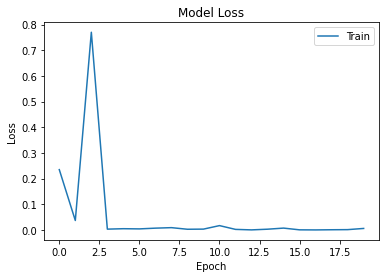

In [44]:
# Plot loss over epochs
my_dpi = 96
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right') 
pyplot.savefig('TF_baselineRanking_20Epochs_Loss.png', dpi=my_dpi * 10,
               bbox_inches='tight')
pyplot.show()

In [45]:
loaded = tf.saved_model.load('rankingBaseline_batch_20epochs')

loaded({'reviewer_id': np.array(['31']), 'item': ['2726956']}).numpy()

array([[4.9651823]], dtype=float32)

In [46]:
# Evaluate
model.evaluate(cached_test, return_dict=True)

200000/200000 [==============================] - 393s 2ms/step - root_mean_squared_error: 1.0860 - loss: 1.1795 - regularization_loss: 0.0000e+00 - total_loss: 1.1795


{'loss': 0.19445449113845825,
 'regularization_loss': 0,
 'root_mean_squared_error': 1.0859835147857666,
 'total_loss': 0.19445449113845825}

## Test the Ranking Model

Compute predictions for a subset of items and rank based on the predictions:


In [47]:
test_ratings = {}
test_item = ['8604928', '12337771', '9897857']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['124382']),
      'item': np.array([item])
  })

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f'{title}: {score}')

Ratings:
8604928: [[3.837846]]
12337771: [[3.837846]]
9897857: [[3.837846]]


## Convert the model to TF Lite to run on-device

In [48]:
converter = tf.lite.TFLiteConverter.from_saved_model('rankingBaseline_batch_20epochs')
tflite_model = converter.convert()
open('converted_model.tflite', 'wb').write(tflite_model)

483592348

In [49]:
interpreter = tf.lite.Interpreter(model_path='converted_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model.
if input_details[0]['name'] == 'serving_default_item:0':
  interpreter.set_tensor(input_details[0]['index'], np.array(['2726956']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['31']))
else:
  interpreter.set_tensor(input_details[0]['index'], np.array(['31']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['2726956']))

interpreter.invoke()

rating = interpreter.get_tensor(output_details[0]['index'])
print(rating)

[[4.965183]]
